# Human Activity Recognition with Smart devices

## Brief Introduction

Human activity recognition is the problem of classifying sequences of sensor data (typically: accelerometer, gyroscope, heart rate) recorded by specialized harnesses or smart devices into known well-defined movements.

The information retrieved from inertial sensors embedded in everyday devices, such as smartphones or smart watches, can be used to classify a set of physical activities through a supervised Machine Learning algorithm.

It is a challenging problem given the large number of observations produced each second, the temporal nature of the observations, and the lack of a clear way to relate sensor data to known movements.

Classical approaches to the problem involve hand crafting features from the time series data based on fixed-size windows and training machine learning models, such as ensembles of decision trees.

Recently, deep learning methods such as recurrent neural networks and convolutional neural networks (CNNs) have been shown to provide state-of-the-art results on challenging activity recognition tasks with little or no data feature engineering.

<br><br><img src="./media/fitbit.png">

## Dataset and Pre-processing

There was a data collection experiment carried out with a group of 5 users. For this initial experiment all participants were wearing a Fitbit smart watch while performing the activities.

Ten acitivities ('Walking','Upstairs','Downstairs','Running','Standing','Sitting','Jumping','Squad','Laying','Situp') were executed by every single participant with a sample collection frequency rate of 10Hz (~10 samples per second). Triaxial acelerometer and gyroscope measurements were captured from the smart watch.

These data signals are sampled at 10Hz and segmented by taking a sliding window frames of 1 second each. The data was labeled, and randomly partitioned into two sub-sets, 70% for the training data and 30% the test data.

__Azure IoT Hub__ solution was used to enable highly secure and reliable communication between an IoT application and the smart devices. The incoming messages were managed and routes to a Storage account via the IoT Hub connection.

<br><br><img src="./media/iot.png"><br><br>

## Approach

This Jupyter Notebook conducts a brief exploratory data analysis to better understand the raw data and its limitations. Starting with a principal component analysis, followed by spliting the dataset into 'window frames' to visualy categorize different activities and finaly building a convolutional neural network.

Furthermore, after building a convolutional neural network. This Jupyter Notebook explore Azure Machine Learning services to run experiments, register a model and deploy it into an Azure Container Instance (ACI) as the staging environment and finally deploy it into an Azure Kubernetes Service (AKS) as the production environment.

Bellow is the index with the main sections.

#### Index:

1. [General analysis](#general_analsis)
    1. [Principal Component Analysis (PCA)](#pca)
    2. [Data Visualization](#data_visualization)
    3. [Convolutional Neural Network Training](#cnn)
4. [Azure Section](#azure)
    1. [Azure Workspace](#azure_workspace)
    2. [Azure Download BlobStorage](#azure_download)
    3. [Azure Upload BlobStorage](#azure_upload)
    4. [Azure Run Experiments](#azure_experiment)
    5. [Azure Experiment Evaluation](#azure_evaluation)
    6. [Azure Model Registry](#azure_registry)
    7. [Azure Model Profiling](#azure_profiling)
    8. [Azure Model Deployment (ACI)](#azure_deployment_aci)
    8. [Azure Model Deployment (AKS)](#azure_deployment_aks)
    9. [Azure Service Testing](#azure_testing)

In [1]:
# Import all necessary Python modules for this Jupyter Notebook
import os
import imp
import json
import pprint
import datetime
import requests
import warnings
import numpy as np
import pandas as pd
import azureml.core
from glob import glob
import Utils as utils
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras import layers, models
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

from azureml.core import Run
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core.model import Model
from azureml.core import Datastore, Dataset
from azureml.core.model import InferenceConfig
from azureml.data import dataset_type_definitions
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.conda_dependencies import CondaDependencies
from azureml.exceptions import WebserviceException, ComputeTargetException
from azureml.core.webservice import Webservice, AciWebservice, AksWebservice

#imp.reload(utils)

<br><br>
## General analysis <a class="anchor" id="general_analsis"></a><br>

__IMPORTANT NOTE__: The next cell must be run at start regardless if you want to run locally or using Azure workspace. You might need to change the *aci_targe_name* and *aks_target_name* variables to match your workspace compute targets.

In [2]:
# Declaring two arrays with the possible ActivityTypes and the Sensor Variables
activity_types = ['Walking','Upstairs','Downstairs','Running','Standing','Sitting','Jumping','Squad','Laying','Situp']
variables = ['AccelX','AccelY','AccelZ','GyroX','GyroY','GyroZ']

# Initialize other variables
model_name = "activity_classifier"
aci_service_name ='sensor-aci'
aks_service_name ='sensor-aks'
aci_target_name = "aci"
aks_target_name = "aks-ssl"

local_path_data_train = os.path.join("data","training")
azure_path_data_train = os.path.join("fitbit","training")

# Loading the very first generated dataset used for exploratory data analysis
df = pd.read_csv(os.path.join("data", "training", "sensor_original.csv"))

<br><br>

## Principal Component Analysis (PCA) <a class="anchor" id="pca"></a><br>

Principal component analysis is a technique for feature extraction. It combines input variables in a specific way, so that we can drop the "least important" (or redundant) variables while still retaining the most valuable parts of all of the variables.

In this particular case, the idea of using PCA is to determine visualy how well does all the different possible output activities can be "clustered" and classified correctly.

The next section will take the first 3 principal components of the sensor dataset and will plot a 3D chart with the activities.

<module 'matplotlib.pyplot' from 'C:\\Users\\AndresQuintanilla\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

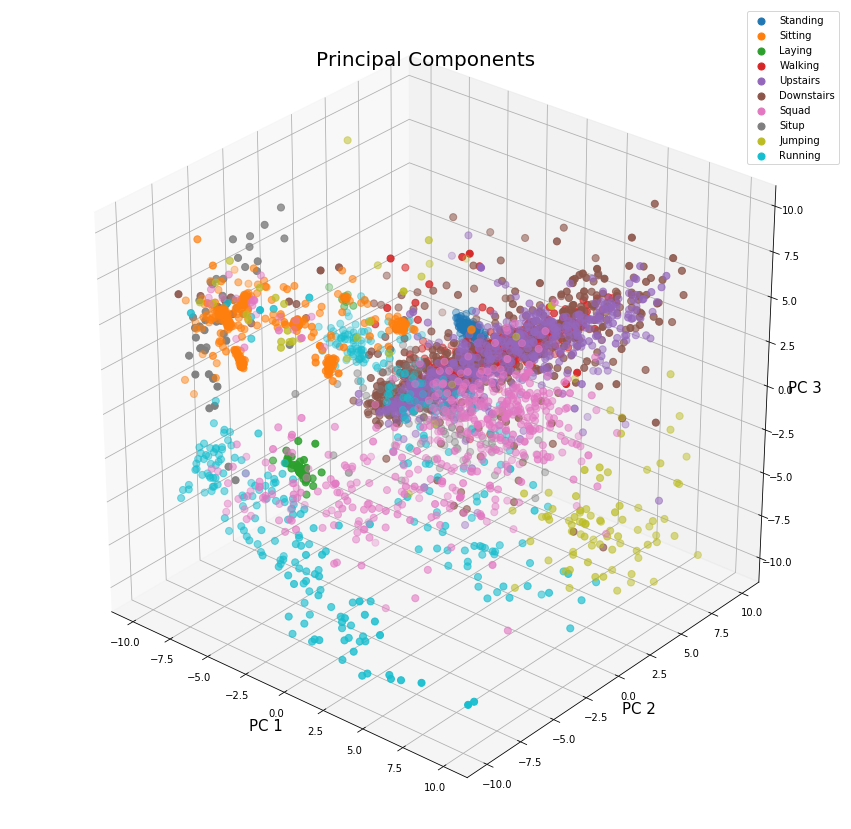

In [3]:
# Get the 3 principal components of the dataset and plot them in a 3D graph to see if we can identify clusters
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df[df.columns.difference(['ActivityID'])])
df_pca = pd.DataFrame(data = df_pca, columns = ['PCA 1', 'PCA 2', 'PCA 3'])
df_pca = pd.concat([df_pca, df[['ActivityID']]], axis = 1)
df_pca = df_pca[(df_pca < 10) & (df_pca > -10)]

# Generate a 3D Plot with the first 3 principal components
utils.plot_3d_pca(df_pca,activity_types)

<br><br>

## Data Visualization (Time Series) <a class="anchor" id="data_visualization"></a><br>

The next section will explore the raw data by spliting the dataset into 'window frames' to visualy categorize different activities and compare them side by side.

The idea is that by generating this 'window frames', each activity would get a 'footprint' by which it could be identified and categorized. Then a convolutional neural network can be trained to accurately classify the activities.

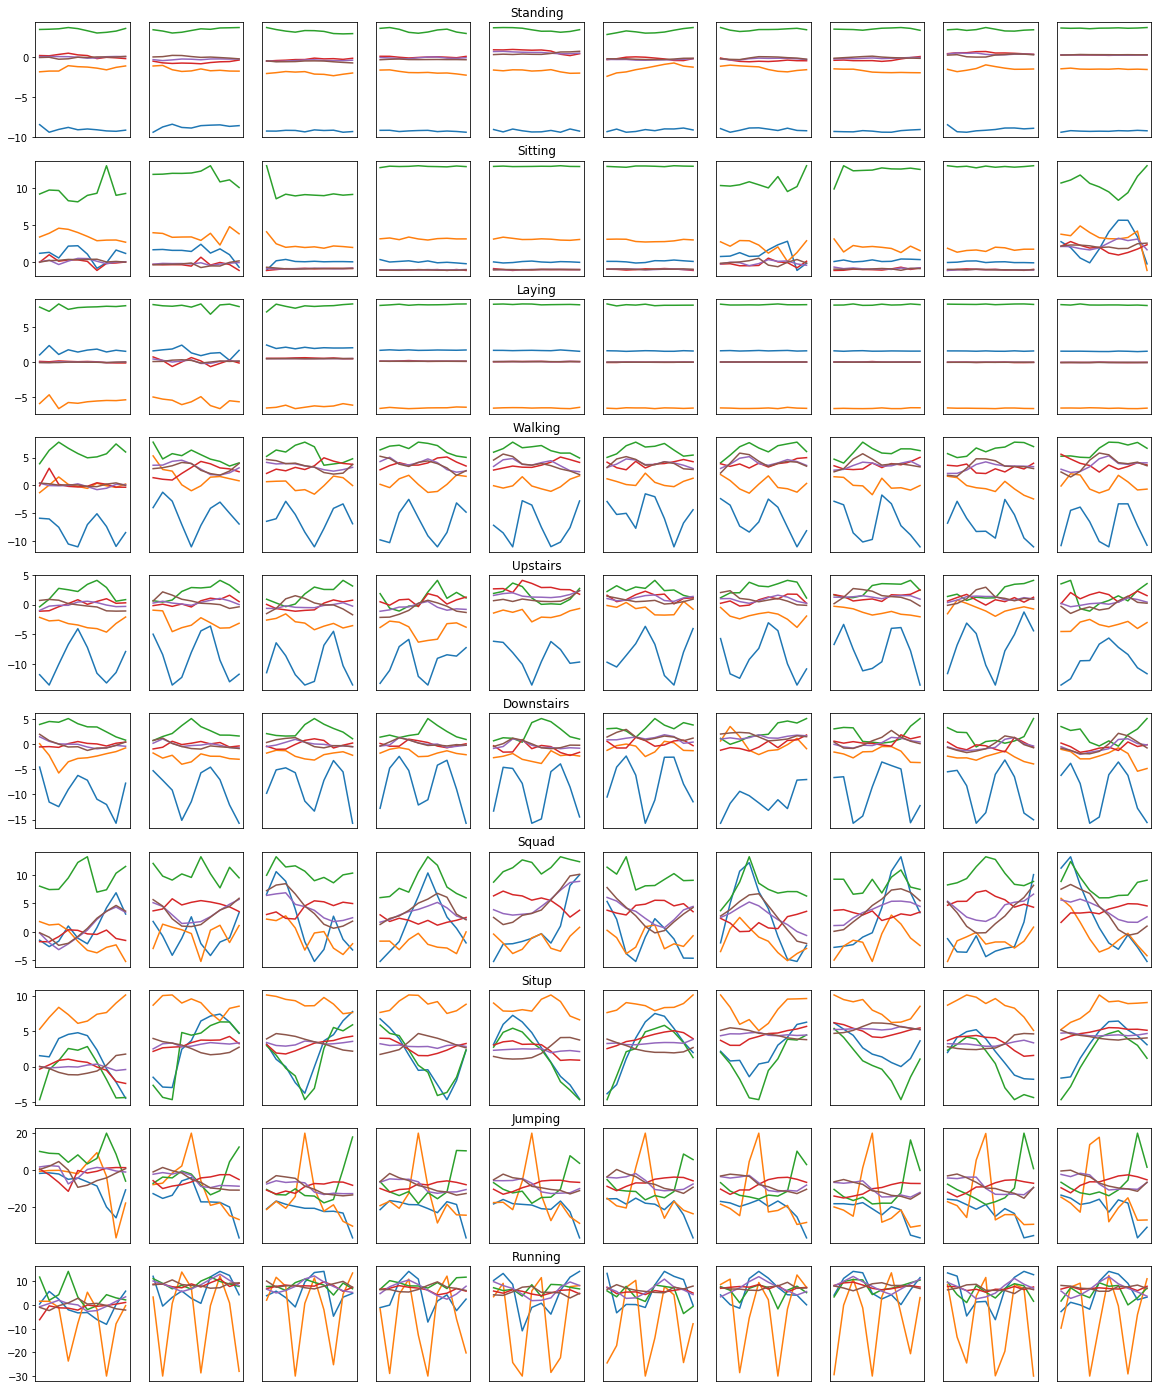

In [4]:
splitFrames = 10
samplesPerFrame = 10
activity_list = df['ActivityID'].unique()
utils.plot_activity_frames(df,variables,activity_list,activity_types,samplesPerFrame,splitFrames).show()

<br><br>

## Convolutional Neural Network Training <a class="anchor" id="cnn"></a><br>

A __convolutional neural network__ consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product. The activation function is commonly a RELU layer, and is subsequently followed by additional convolutions such as pooling layers, fully connected layers and normalization layers, referred to as hidden layers because their inputs and outputs are masked by the activation function and final convolution.

Though the layers are colloquially referred to as convolutions, this is only by convention. Mathematically, it is technically a sliding dot product or cross-correlation. This has significance for the indices in the matrix, in that it affects how weight is determined at a specific index point.

In this section we are going to build a Convolutional Neural Network which general scope is represented by the next image.

<br><img src="./media/cnn.png">

In [5]:
"""
Function to build a Convolutional Neural Network
"""
def build_neural_network(hyperparam, labels):
    ## Configuring the CNN
    frameRange = hyperparam['samplesPerFrame']
    normalizerParam = hyperparam['normalizer']
    regularizerParam = hyperparam['regularizer']
    layer_size = hyperparam['layer_size']
    stride = hyperparam['layer_stride']
    pooling = hyperparam['layer_pooling']
    dropout = hyperparam['layer_dropout']
    
    # Initial input layer a matrix of {N, 6, 1} where N is the 'window frame'
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(frameRange, 6, 1)))
    
    for layer in range(hyperparam['total_layers']):
        # N convolutional layer
        model.add(layers.Conv2D(layer_size[layer], stride[layer], padding='same', activation='relu', kernel_regularizer=regularizerParam))
        model.add(layers.BatchNormalization(momentum=normalizerParam))
        model.add(layers.Conv2D(layer_size[layer], stride[layer], padding='same', activation='relu', kernel_regularizer=regularizerParam))
        model.add(layers.BatchNormalization(momentum=normalizerParam))
        model.add(layers.MaxPooling2D(pooling[layer]))
        model.add(layers.Dropout(dropout[layer]))
        
    # Flatten and dense layer with 'softmax' activation function
    model.add(layers.Flatten())
    model.add(layers.Dense(pd.Series(labels).nunique()+1, activation='softmax'))
    #print(model.summary())
    
    return model

The next code section will use the original dataset and split the raw data into 'window frames' to match the CNN input. For example: if the orignal raw data consists of 1000 samples and the 'window frame' size is 10 samples per frame, the output result will be 100 'dataframes' with shape of {100, 10, 6}

In [6]:
samplesPerFrame = 10  # Note: Each window frame will have exactly this many samples

# Convert raw data into chunks data given a window frame
raw_data , labels = utils.extract_sample_frames(df,samplesPerFrame)

# Extract the train and test datasets
train_data, test_data, train_labels, test_labels = train_test_split(raw_data, labels, test_size=0.3, random_state=123)

The next code section will train the TensorFlow CNN with specific parameters and will save the trained model locally into the 'models' folder. If the folder and files already exists, it will overwrite them.

__NOTE__: this will take some time to execute (depending on the params configuration), if you want to see the details for each epoch while the model is training you just need to set the verbose option in the model.fit function.

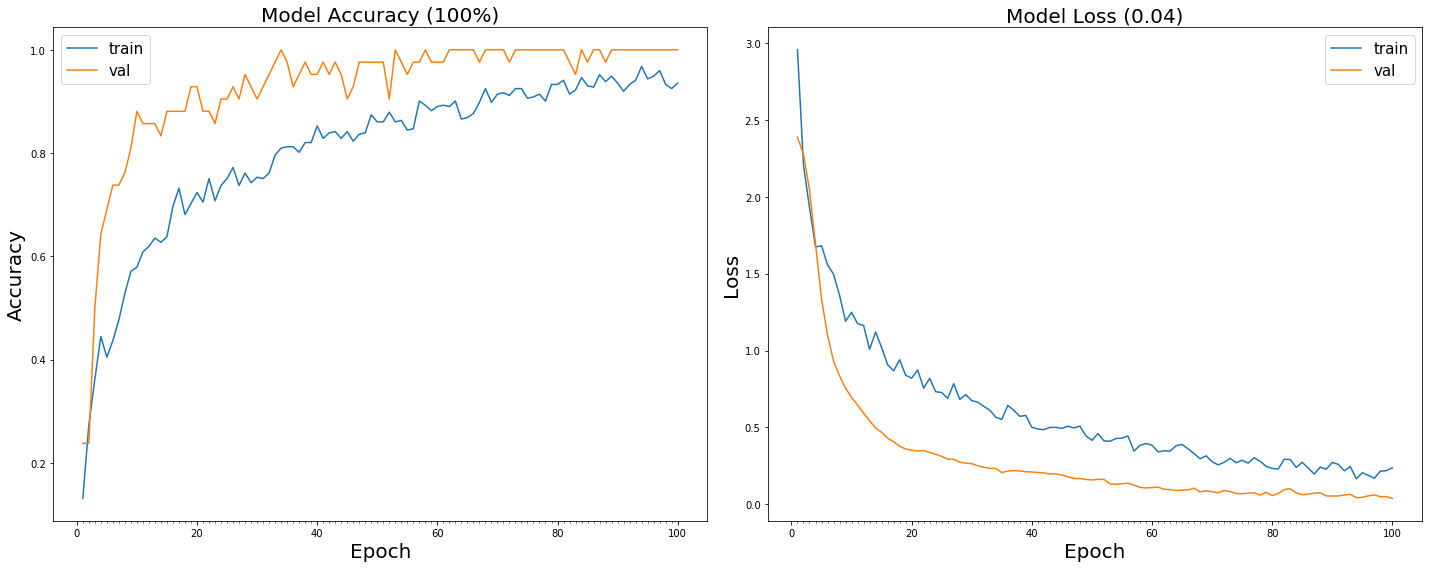



Test Accuracy: 95.51 %


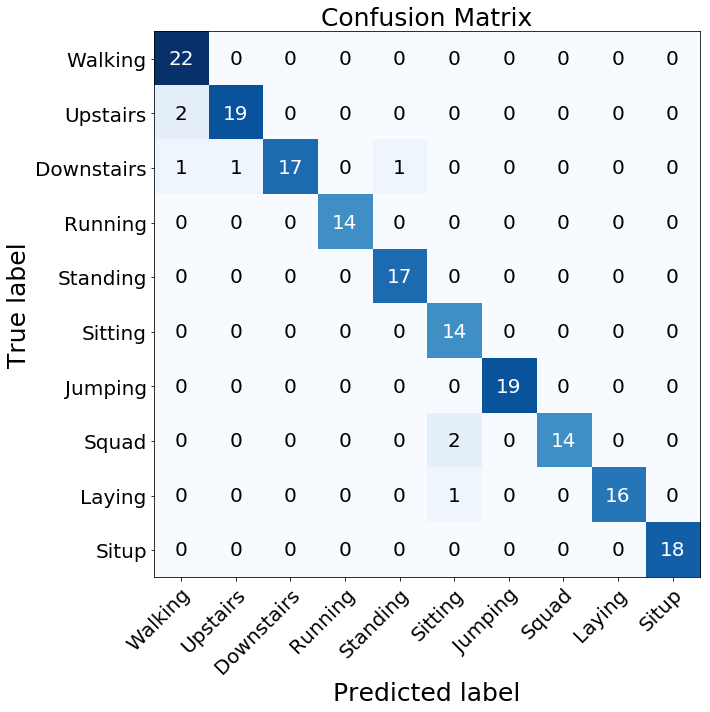

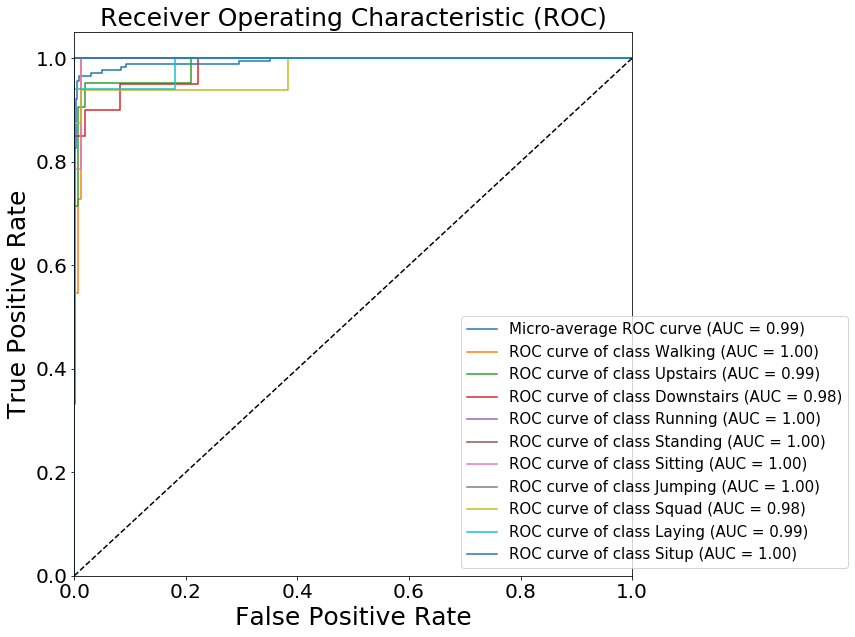

In [8]:
epoch=100
hyperparams = {"samplesPerFrame": samplesPerFrame,
              "regularizer": tf.keras.regularizers.l2(1e-4),
              "normalizer": 0.95,
              "total_layers": 3, 
              "layer_size": [1*samplesPerFrame,2*samplesPerFrame,3*samplesPerFrame],
              "layer_stride": [(4,4),(4,4),(4,4)], 
              "layer_pooling": [(2,2),(2,2),(1,1)], 
              "layer_dropout": [0.2,0.3,0.4]
             }
model = build_neural_network(hyperparams,labels)
optimizerParam = tf.keras.optimizers.Adamax(lr=0.001,decay=1e-4)
model.compile(optimizer=optimizerParam,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=epoch, validation_split = 0.1, verbose=0)

#======================================================================================================

# Going to plot the network history and the confusion matrix to evaluate the training results
utils.plot_network_history(history,figsize_i=(20,8)).show()

# Evaluate the newly trained model using test dataset 
test_loss, test_acc = model.evaluate(test_data, test_labels, batch_size=10, verbose=0)
print("\n\nTest Accuracy: %.2f %%"%(test_acc*100))

# Plot normalized confusion matrix

# Run the model prediction on the test dataset and plot confussion matrix
preds_test = model.predict(test_data)
y_pred = np.argmax(preds_test, axis=1)
act_classes = list(np.array(activity_types)[unique_labels(test_labels, y_pred)])

utils.plot_confusion_matrix(test_labels, y_pred, classes=act_classes).show()
print('\n\n')
utils.plot_roc_curve(test_labels,preds_test,act_classes).show()

tf.saved_model.save(model, os.path.join("models", model_name, "1"))

<br><br><br><br><br><br><br><br><br>

<br><br><img src="./media/azure.png"><br><br>

<a class="anchor" id="azure"></a><br>

## Azure Workspace<a class="anchor" id="azure_workspace"></a><br>

__IMPORTANT NOTE__: You need to update the Azure Workspace configuration file (__azure_ws_config.json__) that is located in the same folder where the Jupyter Notebook is running. You will first need to go to the __Azure Portal__ and create (if you still don't have one) a __Resource Group__ and __Machine Learning Workspace__. Once you have a ML Workspace assigned, go to the workspace __Overview__ page, select "Download config.json" and use those values to replace the variables in your local "azure_ws_config.json"

The next code section will load the workspace into this Jupyter Notebook.

In [10]:
# Try to open an Azure Workspace using a Workspace configuration json file
warnings.filterwarnings('ignore')
try:
    ws_config = json.load(open(os.path.join("config",'azure_ws_config.json')))
    ws = Workspace(subscription_id = ws_config['subscription_id'], resource_group = ws_config['resource_group'], workspace_name = ws_config['workspace_name'])
    ws.write_config()
    print('Workspace configuration succeeded: ' + ws.get_details()['name'])
except:
    print('Workspace not found')

ws = Workspace.from_config()

Workspace configuration succeeded: Andres-ML


<br><br>

## Azure Download BlobStorage<a class="anchor" id="azure_download"></a><br>

__IMPORTANT NOTE__: The next code section will get the default Storage Account from the previously loaded workspace and will try to download ALL the files located in the Blob Container folder __fitbit/raw_input__ into your local drive. Recommendation is that you first double check how many files are in the folder and proceed with caution. Also, it assumes that you have a BlobStarge and files have been already created in the __fitbit/raw_input__ folder, otherwise no file would get downloaded.

In [ ]:
# Download all fitbit raw input data from Workspace datastore to local directory
dstore = ws.get_default_datastore()
dstore.download(target_path=os.path.join("data","azure"), prefix="fitbit/raw_input",show_progress=True)

#### Prepare a combined training dataset with the downloaded files from BlobStorage

After downloading all files from the Blob Container storage into a local drive, the code snippet in the next cell will combine into a single csv file with the run timestamp and move it to the training folder. This would be later utilized to train a new model.

In [ ]:
# Generate a combined CSV file with all the files downloaded from Azure BlobStorage
raw_path = os.path.join("data","azure","fitbit","raw_input")
all_csv_files = [file for path, subdir, files in os.walk(raw_path) for file in glob(os.path.join(path, "*.csv"))]
if len(all_csv_files) > 0:
    df_new_training = pd.concat([pd.read_csv(file) for file in all_csv_files])
    
    # Store the combined CSV file localy (we will upload it later to the datastore)
    t = datetime.datetime.now()
    training_filename = "sensor_%s.csv"%t.strftime("%Y%m%d%H%M%S")
    training_filepath = os.path.join(local_path_data_train,training_filename)
    df_new_training.to_csv(training_filepath, index=False, encoding="utf-8")
    print("New training file %s was created under local folder %s"%(training_filename,training_filepath))

<br><br>

## Azure Upload BlobStorage<a class="anchor" id="azure_upload"></a><br>

__IMPORTANT NOTE__: The next code section will get the default Storage Account from the previously loaded workspace and will try to upload __ALL__ the files from the local training folder __./data/training__ into the Blob Container folder __fitbit/training__. Recommendation is that you first double check how many files are in the folder and proceed with caution.

In [ ]:
# Upload all local files from my data/training folder into the Workspace Default DataStore
dstore = ws.get_default_datastore()

# Upload the original training data set into the Workspace default Datastore (create a specific path for the new training data)
dstore.upload(src_dir=local_path_data_train,target_path=azure_path_data_train,overwrite=True,show_progress=True)

#### Create a new dataframe using Tabular data extracted from Azure BlobStorage

After uploading all files from the local __./data/training__ folder into the Blob Container storage, the next code section will load the file from Blob Container into a Python dataframe and will use it for model training under experiment runs.

In [ ]:
# Get the train file from Azure BlobStorage
datastore_paths = [(dstore, azure_path_data_train.replace('\\', '/') + '/' + training_filename)]
traindata = Dataset.Tabular.from_delimited_files(path=datastore_paths)
df = traindata.to_pandas_dataframe()
print("Azure Dataset Filename:", training_filename)
print("Azure Dataset Columns:", df.columns)
print("Azure Dataset Dimensions: {}".format(df.shape))

<br><br>

<img src="./media/experiment.png"><br>

## Azure Run Experiments <a class="anchor" id="azure_experiment"></a><br>

The next code section will generate several Azure Run Experiments, Depending on the params configuration, a new Run iteration will be created. Also, the model folder generated for each Run iteration will get stored as an output, these files can be later used for deployment, either manual or through code.

To visualize the Run Experiments you can go to your Azure Machine Learning Workspace in the Azure Portal and select "Experiments"

__NOTE__: this will take some time to execute (depending on the params configuration) and iterations, if you want to see the details for each epoch while the model is training you just need to set the verbose option in the model.fit function.

###############################################################################################################
Run number: 1


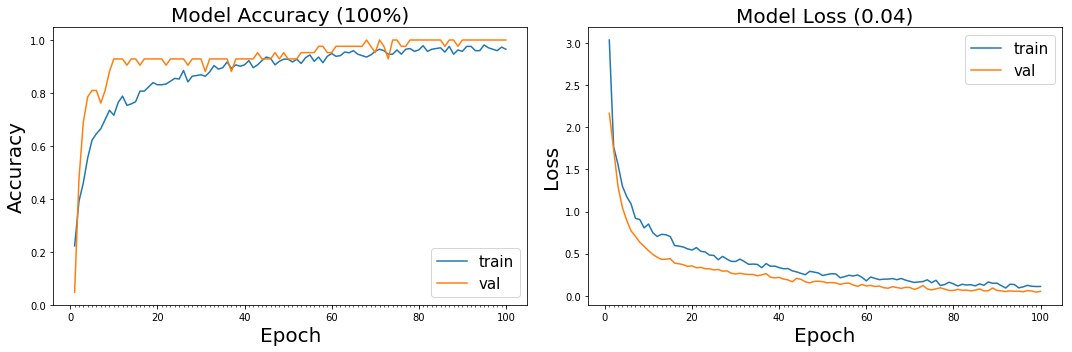



Test Accuracy: 94.38 %


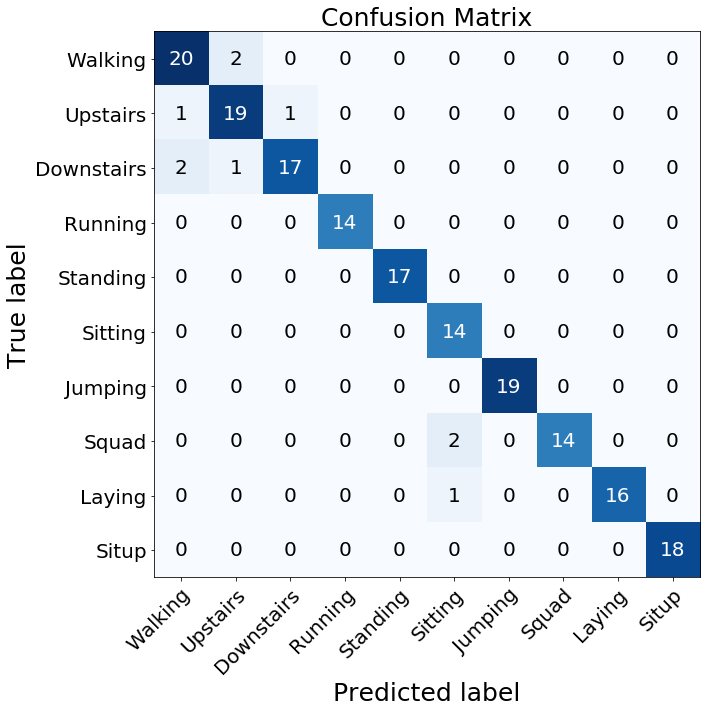

Done with Experiments


In [11]:
# Running an experiment on Azure workspace. The idea is to iterate with different parameters and log the results to compare.
warnings.filterwarnings('ignore')

experiment = Experiment(workspace=ws, name=model_name)
run_number = 1

# Convert raw data into chunks data given a window frame
samplesPerFrame = 10
raw_data , labels = utils.extract_sample_frames(df,samplesPerFrame)

# Extract the train and test datasets
train_data, test_data, train_labels, test_labels = train_test_split(raw_data, labels, test_size=0.3, random_state=123)

for epoch in [100]: #[100,250]:
    for stride_size in [4]: #[2, 4, 6]:
        for layer_num in [2]: #[1, 2, 3]:
            print("###############################################################################################################")
            print("Run number: %d"%run_number)
            run_number+=1
            
            run = experiment.start_logging()
            
            hyperparams = {"samplesPerFrame": samplesPerFrame,
                          "regularizer": tf.keras.regularizers.l2(1e-4),
                          "normalizer": 0.95,
                          "total_layers": layer_num, 
                          "layer_size": [1*samplesPerFrame,2*samplesPerFrame,3*samplesPerFrame],
                          "layer_stride": [(stride_size,stride_size),(stride_size,stride_size),(stride_size,stride_size)], 
                          "layer_pooling": [(2,2),(2,2),(1,1)], 
                          "layer_dropout": [0.2,0.3,0.4]
                         }
            
            model = build_neural_network(hyperparams,labels)
            optimizerParam = tf.keras.optimizers.Adamax(lr=0.001,decay=1e-4)
            
            model.compile(optimizer=optimizerParam,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            history = model.fit(train_data, train_labels, epochs=epoch, validation_split = 0.1, verbose=0)
            
            #======================================================================================================
            
            plot_epochHistory = utils.plot_network_history(history)
            run.log_image("Model Epoch History", plot=plot_epochHistory)
            plot_epochHistory.show()
            
            # Evaluate the newly trained model using test dataset 
            test_loss, test_acc = model.evaluate(test_data, test_labels, batch_size=10, verbose=0)
            print("\n\nTest Accuracy: %.2f %%"%(test_acc*100))
            
            # Run the model prediction on the test dataset and plot confussion matrix
            preds_test = model.predict(test_data)
            y_pred = np.argmax(preds_test, axis=1)
            act_classes = list(np.array(activity_types)[unique_labels(test_labels, y_pred)])
            
            plot_confusionMatrix = utils.plot_confusion_matrix(test_labels, y_pred, classes=act_classes)
            run.log_image("Model ConfusionMatrix", plot=plot_confusionMatrix)
            plot_confusionMatrix.show()
            
            # Log important metrics
            run.log("TestAccuracy", test_acc)
            run.log("TestLoss", test_loss)
            run.log("Epoch", epoch)
            run.log("TotalLayers", layer_num)
            run.log("LayerStride", stride_size)
            run.log("SamplesPerFrame", samplesPerFrame)
            run.log("RunTimeStamp", str(datetime.datetime.now()))

            tf.saved_model.save(model, os.path.join("models", model_name, "1"))
            file_name = os.path.join("models", model_name)
            
            run.upload_folder(name=model_name, path=file_name)
            run.complete()

print("Done with Experiments")

<br><br>

<img src="./media/registry.png"><br>

## Azure Experiment Evaluation <a class="anchor" id="azure_evaluation"></a><br>

After you have generated a few Run Experiments, the next code section will loop through all run iterations and evaluate which was the best model. In this particular case we will utilize the test accuracy as our metric criteria for selecting the best model, that metric was logged into each of the experiments.

In [12]:
# Check which run got the model with the best accuracy and download the .tar file for deployment
warnings.filterwarnings('ignore')

experiment = Experiment(workspace=ws, name=model_name)

exp_run_id = None
max_accuracy = None
run_count = 0

for run in experiment.get_runs():
    run_count+=1
    run_metrics = run.get_metrics()
    run_details = run.get_details()
    # each logged metric becomes a key in this returned dict
    run_accuracy = run_metrics["TestAccuracy"]
    samplesPerFrame = run_metrics["SamplesPerFrame"]
    run_id = run_details["runId"]
    
    if max_accuracy is None:
        max_accuracy = run_accuracy
        exp_run_id = run_id
    else:
        if run_accuracy > max_accuracy:
            max_accuracy = run_accuracy
            exp_run_id = run_id

best_run = Run(experiment=experiment, run_id=exp_run_id)
print(str(experiment).replace("\n"," "))
print("Total Runs: %s"%(run_count))
print("Best Run ID: " + exp_run_id)
print("Best Run Number: %s" %(best_run.number))
print("Best Model Accuracy: %.2f %%"%(max_accuracy*100))

W0505 14:03:03.039674 18296 run.py:637] Run Number's semantics may be modified in the future


Experiment(Name: activity_classifier, Workspace: Andres-ML)
Total Runs: 1
Best Run ID: f75dde13-a2d8-4539-9384-accd68b4dccf
Best Run Number: 1
Best Model Accuracy: 94.38 %


<br><br>

## Azure Model Registry <a class="anchor" id="azure_registry"></a><br>

The next code section will register the best performance model into the Azure Model Registry. In order to do this, we get the Run ID with the best accuracy and download the model files that were stored in the Run output. Finally use the Model.registry API to register our best model into our Azure Machine Learning Workspace. If there is alread a version of the model, a new version will get generated.

To visualize the Models you can go to your Azure Machine Learning Workspace in the Azure Portal and select "Models".

In [13]:
# Check if the model at the best run is already registered (then skip registration)
warnings.filterwarnings('ignore')
register_model = True
try: 
    model_registry = Model(workspace=ws, name=model_name)
    model_tags = model_registry.tags
    register_model = not (model_tags.get("runId") == exp_run_id)
    print("Model: %s (version %s) is already registered with the best experiment run"%(model_registry.name,model_registry.version))
except:
    print("Register new model: %s (version 1)"%model_name)

# Check if there's a need to register a new model
if register_model:
    # Get the run file names using the Run ID and download the folder structure
    model_registry_path = os.path.join("models")
    best_run = Run(experiment=experiment, run_id=exp_run_id)
    best_run.download_files(prefix=model_name, output_directory=model_registry_path)
    
    model_filename = next(os.walk(model_registry_path))[1][0]
    
    # Register Model!
    model_registry = Model.register(model_name=model_name,
                           model_path = os.path.join(model_registry_path, model_filename),
                           model_framework=Model.Framework.TENSORFLOW,
                           model_framework_version=tf.__version__,
                           tags={'experiment': experiment.name, 'runId': exp_run_id, 'runNumber': best_run.number},
                           description="TensorFlow model that recives raw data from smart device senors and predicts/classifies the activity peformed by the person wearing the watch.",
                           workspace=ws)
    
    print('Model Name:', model.name)
    print('Model Path:', os.path.join(model_registry_path, model_filename))

Register new model: activity_classifier (version 1)


W0505 14:03:31.072686 18296 run.py:637] Run Number's semantics may be modified in the future


Registering model activity_classifier
Model Name: sequential_2
Model Path: models\activity_classifier


<br><br>

## Write Entry 'score.py' Script for Web Services

The next code section will create a score.py file that is used for inference scoring on the Web Services (ACI | AKS). This __score.py__ will be used when deploying your model.

__IMPORTANT NOTE__: The variables *accountName*, *accountKey*, and *containerName* must be updated matching your Workspace BlobStorage. To get this information, go to the Azure Portal -> Storage Accounts; select the *Account Name* that corresponds to your Workspace default; there is an *Access Keys* section under *Settings* menu; and finally there is a *Containers* section under *Blob Services* menu. Another way to get those variable values is through python code from the Workspace object that was previously generated here in this Jupyter Notebook.

In [ ]:
%%writefile ./deployment/score.py
import io
import os
import json
import numpy 
import time
import pandas
import datetime
import tensorflow as tf

from azureml.core.model import Model
#from azure.storage.blob import BlockBlobService

def init():
    global model

    print ("model initialized" + time.strftime("%H:%M:%S"))
    model_path = Model.get_model_path(model_name = 'activity_classifier') + "/1"
    model = tf.keras.models.load_model(model_path)
    
def run(raw_data):
    try:
        data = json.loads(raw_data)["data"]
        data = numpy.array(data)
        result_full = model.predict(data)
        result = numpy.argmax(result_full, axis=1)
        return json.dumps({"result": result.tolist(), "result_full": result_full.tolist()})
        #if data.shape[2] == 6:
        #    result_full = model.predict(data)
        #    result = numpy.argmax(result_full, axis=1)
        #    return json.dumps({"result": result.tolist(), "result_full": result_full.tolist()})
        #elif data.shape[2] == 7:
        #    output = io.StringIO()
        #    df_raw_input = data.reshape(data.shape[0]*data.shape[1],7)
        #    df_raw_input = pandas.DataFrame(df_raw_input,columns=['ActivityID','AccelX','AccelY','AccelZ','GyroX','GyroY','GyroZ'])
        #    df_raw_input['ActivityID'] = df_raw_input['ActivityID'].astype(numpy.int)
        #    output = df_raw_input.to_csv(index=False, encoding = "utf-8")
        #    accountName = "<AZURE_STORAGE_NAME>"
        #    accountKey = "<AZURE_STORAGE_KEY>"
        #    containerName = "<AZURE_STORAGE_CONTAINER>"
        #    t = datetime.datetime.now()
        #    file_name = "sensor_raw_%s.csv"%(t.strftime("%Y%m%d%H%M%S"))
        #    blobService = BlockBlobService(account_name=accountName, account_key=accountKey)
        #    blobService.create_blob_from_text(containerName, os.path.join("fitbit","raw_input",t.strftime("%Y%m%d"),file_name), output)
        #    return json.dumps({"result": "Upload Raw Input to BlobStorage"})

    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})

<br><br>

## Azure Model Profiling <a class="anchor" id="azure_profiling"></a><br>

Profile our model to understand how much CPU and memory the service, created as a result of its deployment, will need. Profiling returns information such as CPU usage, memory usage, and response latency. It also provides a CPU and memory recommendation based on the resource usage. You can profile your model (or more precisely the service built based on your model) on any CPU and/or memory combination where 0.1 <= CPU <= 3.5 and 0.1GB <= memory <= 15GB. If you do not provide a CPU and/or memory requirement, we will test it on the default configuration of 3.5 CPU and 15GB memory.


__IMPORTANT NOTE__: Before you run the Model Profiling, make sure you update and run __Write Entry 'score.py' Script for Web Services__ code section above and provide the correct Account Name, Account Key and Container Name.

In [23]:
# Register a datasets into the workspace so they can be shared with others and used for profiling
dataset_name='sample_request_data'

dataset_registered = False
try:
    sample_request_data = Dataset.get_by_name(workspace = ws, name = dataset_name)
    dataset_registered = True
except:
    print("The dataset {} is not registered in workspace yet.".format(dataset_name))

if not dataset_registered:
    input_json = {"data":[
        [
          [[-8.3046875],[-3.171875],[4.1328125],[0.3642578125],[0.2247314453125],[0.19287109375]],
          [[-8.640625],[-2.765625],[3.966796875],[-0.0234375],[0.13427734375],[0.24072265625]],
          [[-8.8671875],[-3.09375],[3.478515625],[-0.29296875],[0.0894775390625],[0.1566162109375]],
          [[-9.046875],[-3.125],[3.494140625],[-0.0298309326171875],[0.150146484375],[0.12890625]],
          [[-9.15625],[-2.841796875],[3.404296875],[-0.043670654296875],[0.05218505859375],[0.1331787109375]],
          [[-8.96875],[-2.66796875],[3.375],[-0.1746826171875],[-0.0863037109375],[0.050079345703125]],
          [[-8.640625],[-2.578125],[3.357421875],[0.09161376953125],[-0.031951904296875],[0.09478759765625]],
          [[-9.234375],[-2.51953125],[3.447265625],[0.184326171875],[0.137451171875],[0.2685546875]],
          [[-8.4765625],[-2.162109375],[3.478515625],[0.31103515625],[0.1885986328125],[0.07244873046875]],
          [[-8.8515625],[-1.6865234375],[3.583984375],[0.19921875],[0.085205078125],[0.03302001953125]]
        ]
    ]*100}
    
    # create a string that can be put in the body of the request
    serialized_input_json = json.dumps(input_json)
    dataset_content = []
    for i in range(300):
        dataset_content.append(serialized_input_json)
    sample_request_data = '\n'.join(dataset_content)
    file_name = "{}.txt".format(dataset_name)
    f = open(os.path.join("data",file_name), 'w')
    f.write(sample_request_data)
    f.close()

    # upload the txt file created above to the Datastore and create a dataset from it
    dstore = ws.get_default_datastore()
    dstore.upload_files([os.path.join(".","data",file_name).replace("\\","/")],target_path='sample_request_data',overwrite=True)  

    datastore_path = [(dstore, 'sample_request_data' + '/' + file_name)]
    sample_request_data = Dataset.Tabular.from_delimited_files(
        datastore_path,
        separator='\n',
        infer_column_types=True,
        header=dataset_type_definitions.PromoteHeadersBehavior.NO_HEADERS)
    sample_request_data = sample_request_data.register(workspace=ws, name=dataset_name, create_new_version=True)

The dataset sample_request_data is not registered in workspace yet.
Uploading an estimated of 1 files
Uploading ./data/sample_request_data.txt
Uploaded ./data/sample_request_data.txt, 1 files out of an estimated total of 1
Uploaded 1 files


Now that we have an input dataset we are ready to go ahead with profiling. In this case we are testing the registered model on 1 CPU and 0.5 GB memory. The memory usage and recommendation presented in the result is measured in Gigabytes. The CPU usage and recommendation is measured in CPU cores.

In [24]:
# Create a Scoring Enviroment with all the conda packages needed.
environment = Environment('scoring_environment')
conda_pack = ['pandas','numpy','tensorflow']
#pip_pack = ['azureml-defaults', 'azure-storage','inference-schema[numpy-support]', 'pandas', 'numpy','tensorflow']
pip_pack = ['azureml-defaults', 'inference-schema[numpy-support]', 'pandas', 'numpy','tensorflow']
environment.python.conda_dependencies = CondaDependencies.create(conda_packages=conda_pack, pip_packages=pip_pack)

# Create the inference config that will be used when deploying the model
score_script_path = os.path.join("deployment","score.py")
inf_config = InferenceConfig(entry_script=score_script_path, environment=environment)

# If cpu and memory_in_gb parameters are not provided the model will be profiled on default configuration of 3.5CPU and 15GB memory
profile = Model.profile(ws,
                        'tf-%s' % datetime.datetime.now().strftime('%Y%m%d%H%M%S'),
                        [model_registry],
                        inf_config,
                        input_dataset=sample_request_data,
                        cpu=1.0,
                        memory_in_gb=0.5)

profile.wait_for_completion(True)
details = profile.get_details()
pd.DataFrame(details.values(), index=details.keys(), columns=['Value'])

Running.......................................................................................................
Succeeded


,Value
name,tf-20200505151623
createdTime,2020-05-05T20:16:29.381175+00:00
state,Succeeded
requestedCpu,1
requestedMemoryInGB,0.5
requestedQueriesPerSecond,0
maxUtilizedMemoryInGB,0.298455
totalQueries,300
successQueries,300
successRate,100


<br><br>

<img src="./media/deploy.png"><br><br>

## Azure Model Deployment (ACI) <a class="anchor" id="azure_deployment_aci"></a><br>

After registering the model we will use it to deploy an Azure Container Instance service, where we can test and score the model. Think about the ACI as the Stagging or QA environment. For now, we will be creating an ACI with the default 'Deploy Configurations', but this can be modified to meet your model scope.

__IMPORTANT NOTE__: Before you deploy to ACI, make sure you update and run __Write Entry 'score.py' Script for Web Services__ code section above and provide the correct Account Name, Account Key and Container Name.

__IMPORTANT NOTE__: In order to create a the ACI web service you first need to create a Training ComputeTarget in your workspace. This can be done through Python code, but since I already had ComputeTargets created on my Machine Learning Workspace I am skipping that step and utilizing previously created ones. You can manually creat them by going to your Machine Learning Workspace and select _Compute_ under _Asstes_, then _Training Clusters_ for ACI or _Inference Clusters_ for AKS, from there you can select your prefered ComputeTarget configuration. Finally use the name and replace the __aci_target_name__ variable at the beginig of this Jupyter Notebook.

In [26]:
# =============================================================================
## Provision the ACI Compute Target
## Use the default configuration 
#prov_config = AciCompute.provisioning_configuration()
#aci_target = ComputeTarget.create(workspace = ws, name = 'aci', provisioning_configuration = prov_config)
# =============================================================================

# Get the registered model
model_registry = Model(workspace=ws, name=model_name)

# Create a Scoring Enviroment with all the conda packages needed.
environment = Environment('scoring_environment')
conda_pack = ['pandas','numpy','tensorflow']
#pip_pack = ['azureml-defaults', 'azure-storage','inference-schema[numpy-support]', 'pandas', 'numpy','tensorflow']
pip_pack = ['azureml-defaults', 'inference-schema[numpy-support]', 'pandas', 'numpy','tensorflow']
environment.python.conda_dependencies = CondaDependencies.create(conda_packages=conda_pack, pip_packages=pip_pack)

# Create the inference config that will be used when deploying the model
score_script_path = os.path.join("deployment","score.py")
inf_config = InferenceConfig(entry_script=score_script_path, environment=environment)

# Set the web service configuration (using default here)
aci_config = AciWebservice.deploy_configuration()

# Get the web service ComputeTarget (previously created)
aci_target = ComputeTarget(workspace=ws, name=aci_target_name)

# Deploy AKS Web Service
# Remove any existing service under the same name.
try:
    Webservice(ws, aci_service_name).delete()
except WebserviceException:
    pass

# Create new ACI Service
aci_service = Model.deploy(workspace=ws,
                           name=aci_service_name,
                           models=[model_registry],
                           inference_config=inf_config,
                           deployment_config=aci_config,
                           deployment_target=aci_target,
                           overwrite=True)

aci_service.wait_for_deployment(show_output = True)
print(aci_service.state)

Running..............................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


<br><br>

## Azure Model Deployment (AKS) <a class="anchor" id="azure_deployment_aks"></a><br>

After registering the model we will use it to deploy an Azure Kubernetes Service, where we can test and score the model. Think about the AKS as the Production environment. For now, we will be creating an AKS with the default 'Deploy Configurations', but this can be modified to meet your model scope.

__IMPORTANT NOTE__: Before you deploy to AKS, make sure you update and run __Write Entry 'score.py' Script for Web Services__ code section above and provide the correct Account Name, Account Key and Container Name. 

__IMPORTANT NOTE__: In order to create a the AKS web service you first need to create an Inference ComputeTarget in your workspace. This can be done through Python code, but since I already had ComputeTargets created on my Machine Learning Workspace I am skipping that step and utilizing previously created ones. You can manually creat them by going to your Machine Learning Workspace and select _Compute_ under _Asstes_, then _Training Clusters_ for ACI or _Inference Clusters_ for AKS, from there you can select your prefered ComputeTarget configuration. Finally use the name and replace the __aks_target_name__ variable at the beginig of this Jupyter Notebook.

In [27]:
# =============================================================================
## Provision the AKS Compute Target
## Use the default configuration 
#prov_config = AciCompute.provisioning_configuration()
#aks_target = ComputeTarget.create(workspace = ws, name = 'aks', provisioning_configuration = prov_config)
# =============================================================================

# Get the registered model
model_registry = Model(workspace=ws, name=model_name)

# Create a Scoring Enviroment with all the conda packages needed.
environment = Environment('scoring_environment')
conda_pack = ['pandas','numpy','tensorflow']
#pip_pack = ['azureml-defaults', 'azure-storage','inference-schema[numpy-support]', 'pandas', 'numpy','tensorflow']
pip_pack = ['azureml-defaults', 'inference-schema[numpy-support]', 'pandas', 'numpy','tensorflow']
environment.python.conda_dependencies = CondaDependencies.create(conda_packages=conda_pack, pip_packages=pip_pack)

# Create the inference config that will be used when deploying the model
score_script_path = os.path.join("deployment","score.py")
inf_config = InferenceConfig(entry_script=score_script_path, environment=environment)

# Set the web service configuration (using default here)
aks_config = AksWebservice.deploy_configuration()

# Get the web service ComputeTarget (previously created)
aks_target = ComputeTarget(workspace=ws, name=aks_target_name)

# Deploy AKS Web Service
# Remove any existing service under the same name.
try:
    Webservice(ws, aks_service_name).delete()
except WebserviceException:
    pass

# Create new AKS Service
aks_service = Model.deploy(workspace=ws,
                           name=aks_service_name,
                           models=[model_registry],
                           inference_config=inf_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           overwrite=True)

aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

Running.....
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy


<br><br>

<img src="./media/inference.png"><br><br>

## Azure Service Testing (ACI and AKS) <a class="anchor" id="azure_testing"></a><br>

After succesfully creating your ACI and/or AKS web service, we will proceed to test the currently deployed models with some dummy data.

The model inference can be accessed through a Post Request using the provided URI in the Azure Machine Learning Workspace, under _Deployments_. When sending requests through AKS, you will also need a Key that is also provided in the _Deployments_ section on the Azure Machine Learning Workspace.

In [31]:
# Prepare the data and headers to send a post request to the scoring services
headers = {'Content-Type': 'application/json'}
input_data = json.dumps({"data":[
    [
      [[-8.3046875],[-3.171875],[4.1328125],[0.3642578125],[0.2247314453125],[0.19287109375]],
      [[-8.640625],[-2.765625],[3.966796875],[-0.0234375],[0.13427734375],[0.24072265625]],
      [[-8.8671875],[-3.09375],[3.478515625],[-0.29296875],[0.0894775390625],[0.1566162109375]],
      [[-9.046875],[-3.125],[3.494140625],[-0.0298309326171875],[0.150146484375],[0.12890625]],
      [[-9.15625],[-2.841796875],[3.404296875],[-0.043670654296875],[0.05218505859375],[0.1331787109375]],
      [[-8.96875],[-2.66796875],[3.375],[-0.1746826171875],[-0.0863037109375],[0.050079345703125]],
      [[-8.640625],[-2.578125],[3.357421875],[0.09161376953125],[-0.031951904296875],[0.09478759765625]],
      [[-9.234375],[-2.51953125],[3.447265625],[0.184326171875],[0.137451171875],[0.2685546875]],
      [[-8.4765625],[-2.162109375],[3.478515625],[0.31103515625],[0.1885986328125],[0.07244873046875]],
      [[-8.8515625],[-1.6865234375],[3.583984375],[0.19921875],[0.085205078125],[0.03302001953125]]
    ],
#    [
#      [[-4.84375],[-2.837890625],[3.724609375],[-2.654296875],[0.87451171875],[1.599609375]],
#      [[-7.609375],[-4.9609375],[5.07421875],[-1.576171875],[1.244140625],[1.39453125]],
#      [[-11.7578125],[-7.12109375],[3.591796875],[-0.7744140625],[1.2744140625],[1.2197265625]],
#      [[-12.3359375],[-6.84375],[3.390625],[0.85546875],[0.52099609375],[0.4677734375]],
#      [[-10.3671875],[-4.17578125],[2.650390625],[1.373046875],[-0.395263671875],[-0.68701171875]],
#      [[-6.3203125],[-1.7607421875],[2.21875],[1.1845703125],[-1.29296875],[-1.560546875]],
#      [[-8.3203125],[-2.345703125],[1.3935546875],[1.20703125],[-1.513671875],[-1.17578125]],
#      [[-9.5703125],[-2.81640625],[2.224609375],[0.482666015625],[-0.91845703125],[-0.337646484375]],
#      [[-10.3671875],[-1.705078125],[4.16796875],[-0.41015625],[0.12359619140625],[0.38134765625]],
#      [[-10.1953125],[-1.3408203125],[4.25390625],[-0.331298828125],[0.79150390625],[0.6689453125]]
#    ],
#    [
#      [[0.35205078125],[1.5205078125],[11.671875],[-6.24609375],[-0.775390625],[-1.046875]],
#      [[5.65234375],[1.484375],[1.9189453125],[-0.4091796875],[0.5400390625],[-2.40625]],
#      [[2.35546875],[-0.96826171875],[4.27734375],[-1.2509765625],[1.93359375],[-0.365478515625]],
#      [[-2.07421875],[-23.625],[14.0703125],[-1.38671875],[0.5283203125],[0.7998046875]],
#      [[-3.361328125],[-7.765625],[3.29296875],[-2.212890625],[-0.031951904296875],[2.75]],
#      [[-3.23828125],[5.30859375],[-1.9931640625],[-0.06500244140625],[-2.7734375],[0.33544921875]],
#      [[-6.17578125],[-1.7802734375],[-0.36865234375],[-0.6005859375],[-2.400390625],[0.62646484375]],
#      [[-8.1953125],[-29.921875],[4.28125],[-0.254638671875],[-0.63916015625],[-0.29296875]],
#      [[0.136474609375],[-7.9765625],[2.927734375],[0.320556640625],[1.48046875],[-1.6435546875]],
#      [[5.75390625],[-0.3291015625],[2.07421875],[1.017578125],[3.3828125],[-2.185546875]]
#    ]
  ]
})

### ACI - Azure Container Instance Service

In [34]:
if aci_service.auth_enabled:
    headers['Authorization'] = 'Bearer '+ aci_service.get_keys()[0]
elif aci_service.token_auth_enabled:
    headers['Authorization'] = 'Bearer '+ aci_service.get_token()[0]

scoring_uri = aci_service.scoring_uri
response = requests.post(scoring_uri, data=input_data, headers=headers)
res_json = json.loads(response.json())

res_final = []
for res_i in res_json['result_full']:
    res_i = [round(num, 2) for num in res_i]
    res_final.append(list(map(lambda x, y:(x,y), res_i, activity_types)))


print("ACI Service URI: %s (response: %s)\n"%(scoring_uri,response.status_code))
print("ACI Response JSON:")
pprint.PrettyPrinter(indent=2).pprint(res_final)
print("")
print("ACI Response Final: %s"%[activity_types[i] for i in res_json['result']])

ACI Response JSON:
[ [ (0.01, 'Walking'),
    (0.0, 'Upstairs'),
    (0.0, 'Downstairs'),
    (0.0, 'Running'),
    (0.99, 'Standing'),
    (0.0, 'Sitting'),
    (0.0, 'Jumping'),
    (0.0, 'Squad'),
    (0.0, 'Laying'),
    (0.0, 'Situp')]]

ACI Response Final: ['Standing']


### AKS - Azure Kubernetes Service

In [35]:
if aks_service.auth_enabled:
    headers['Authorization'] = 'Bearer '+ aks_service.get_keys()[0]
elif aks_service.token_auth_enabled:
    headers['Authorization'] = 'Bearer '+ aks_service.get_token()[0]

scoring_uri = aks_service.scoring_uri
response = requests.post(scoring_uri, data=input_data, headers=headers)
res_json = json.loads(response.json())

res_final = []
for res_i in res_json['result_full']:
    res_i = [round(num, 2) for num in res_i]
    res_final.append(list(map(lambda x, y:(x,y), res_i, activity_types)))


print("AKS Service URI: %s (response: %s)\n"%(scoring_uri,response.status_code))
print("AKS Response JSON:")
pprint.PrettyPrinter(indent=2).pprint(res_final)
print("")
print("AKS Response Final: %s"%[activity_types[i] for i in res_json['result']])

AKS Response JSON:
[ [ (0.01, 'Walking'),
    (0.0, 'Upstairs'),
    (0.0, 'Downstairs'),
    (0.0, 'Running'),
    (0.99, 'Standing'),
    (0.0, 'Sitting'),
    (0.0, 'Jumping'),
    (0.0, 'Squad'),
    (0.0, 'Laying'),
    (0.0, 'Situp')]]

AKS Response Final: ['Standing']


In [36]:
# Delete Web Services (ACI and ASK)
aci_service.delete()
aks_service.delete()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## Azure Model Training (Compute Target) -- NOT USED

__IMPORTANT NOTE__: Use the azure compute target clusters to training models ONLY if it's extremly necessary, meaning there's a lot of computation needed. Other wise, use simple compute instances within the Azure Notebooks

In [ ]:
# =============================================================================
#
#from azureml.core import ScriptRunConfig
#from azureml.core.runconfig import RunConfiguration
#from azureml.core.conda_dependencies import CondaDependencies
#from azureml.core.runconfig import DEFAULT_CPU_IMAGE
#
###################################################################
### Edit a run configuration property on the fly.
##run_local = RunConfiguration()
##
##run_local.environment.python.user_managed_dependencies = True
###################################################################
#
## Create a new experiment
#experiment = Experiment(workspace=ws, name="sensor_neuralnetwork_training")
#
## Get a compute target (need to create it first, either manually or through code)
#cpu_cluster = ComputeTarget(workspace=ws, name='cpu-cluster-ml')
#
## Create a new runconfig object
#run_amlcompute = RunConfiguration()
#
## Use the cpu_cluster you created above. 
#run_amlcompute.target = cpu_cluster
#
## Enable Docker
#run_amlcompute.environment.docker.enabled = True
#
## Set Docker base image to the default CPU-based image
#run_amlcompute.environment.docker.base_image = DEFAULT_CPU_IMAGE
#
## Use conda_dependencies.yml to create a conda environment in the Docker image for execution
#run_amlcompute.environment.python.user_managed_dependencies = False
#
## Specify CondaDependencies obj, add necessary packages
#run_amlcompute.environment.python.conda_dependencies = CondaDependencies.create(conda_packages=['scikit-learn','tensorflow','numpy','pandas','matplotlib'])
#
## Specify the train.py script and submit the experiment
#script_folder = os.getcwd()
#src = ScriptRunConfig(source_directory = script_folder, script = 'train.py', run_config = run_amlcompute)
##src.run_config.node_count = 2
#run = experiment.submit(src)
#run.wait_for_completion(show_output = True)
#
#print(run.get_portal_url())
#
# =============================================================================